# Insights from Failed Orders

link to problem : [strata scratch](https://platform.stratascratch.com/data-projects/insights-failed-orders)

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

Please complete the following tasks.

1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

4. Plot the distribution of average ETA by hours. How can this plot be explained?

5. BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

## Data Description

We have two data sets: `data_orders` and `data_offers`, both being stored in a CSV format. 

### The data_orders data set contains the following columns:

order_datetime - time of the order

origin_longitude - longitude of the order

origin_latitude - latitude of the order

m_order_eta - time before order arrival

order_gk - order number

order_status_key - status, an enumeration consisting of the following mapping:

    4 - cancelled by client,

    9 - cancelled by system, i.e., a reject

is_driver_assigned_key - whether a driver has been assigned

cancellation_time_in_seconds - how many seconds passed before cancellation


### The data_offers data set is a simple map with 2 columns:

order_gk - order number, associated with the same column from the orders data set

offer_id - ID of an offer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
ofdf = pd.read_csv("data_offers.csv")
ofdf

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196
...,...,...
334358,3000552921666,300050611632
334359,3000593796526,300051443024
334360,3000590955748,300051340498
334361,3000557510943,300050772593


In [48]:
ordf = pd.read_csv("data_orders.csv")
ordf

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0


In [61]:
# Merge data
merged_data = pd.merge(ordf, ofdf, on='order_gk', how='left')

In [49]:
ordf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [50]:
pd.to_timedelta(ordf['order_datetime'].str.strip())


0       0 days 18:08:07
1       0 days 20:57:32
2       0 days 12:07:50
3       0 days 13:50:20
4       0 days 21:24:45
              ...      
10711   0 days 13:11:35
10712   0 days 13:13:55
10713   0 days 13:17:21
10714   0 days 13:16:28
10715   0 days 11:49:35
Name: order_datetime, Length: 10716, dtype: timedelta64[ns]

In [51]:
ordf.isna().sum()

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64

In [52]:
ordf = ordf.fillna(-1)
ordf

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,-1.0,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,-1.0,3000583140877,9,0,-1.0
...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,-1.0,3000599186906,4,0,36.0
10712,13:13:55,-0.975372,51.457846,-1.0,3000599186962,4,0,4.0
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0
10714,13:16:28,-0.975372,51.457846,-1.0,3000599187024,4,0,6.0


In [53]:
ordf.describe()

,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
count,10716.000000,10716.000000,10716.000000,1.071600e+04,10716.000000,10716.000000,10716.000000
mean,-0.964323,51.450541,115.177398,3.000598e+12,5.590612,0.262598,107.344905
std,0.022818,0.011984,244.297372,2.396261e+07,2.328845,0.440066,191.098070
min,-1.066957,51.399323,-1.000000,3.000550e+12,4.000000,0.000000,-1.000000
25%,-0.974363,51.444643,-1.000000,3.000583e+12,4.000000,0.000000,-1.000000
50%,-0.966386,51.451972,-1.000000,3.000595e+12,4.000000,0.000000,47.000000
75%,-0.949605,51.456725,60.000000,3.000623e+12,9.000000,1.000000,139.000000
max,-0.867088,51.496169,1559.000000,3.000633e+12,9.000000,1.000000,4303.000000


### 1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. 

### Analyse the resulting plot. Which category has the highest number of orders?

In [58]:
#splitting the cancellation records before(b) and after(a) driver assignment 
can_b = ordf[(ordf.is_driver_assigned_key == 0)]
can_a = ordf[(ordf.is_driver_assigned_key == 1)]

In [62]:
# Categorize failures
cancelled_by_client = merged_data[merged_data['order_status_key'] == 4]
cancelled_by_system = merged_data[(merged_data['order_status_key'] == 9) & (merged_data['is_driver_assigned_key'] == 0)]
rejected_by_drivers = merged_data[(merged_data['is_driver_assigned_key'] == 0) & merged_data['offer_id'].isnull()]

# Calculate counts for each category
cancelled_by_client_count = cancelled_by_client.shape[0]
cancelled_by_system_count = cancelled_by_system.shape[0]
rejected_by_drivers_count = rejected_by_drivers.shape[0]

In [64]:
# Display the distribution
print("Distribution of orders according to reasons for failure")
print(f"Cancelled by client: {cancelled_by_client_count} orders")
print(f"Cancelled by system: {cancelled_by_system_count} orders")
print(f"Rejected by drivers: {rejected_by_drivers_count} orders")

Distribution of orders according to reasons for failure
Cancelled by client: 23397 orders
Cancelled by system: 10972 orders
Rejected by drivers: 2632 orders


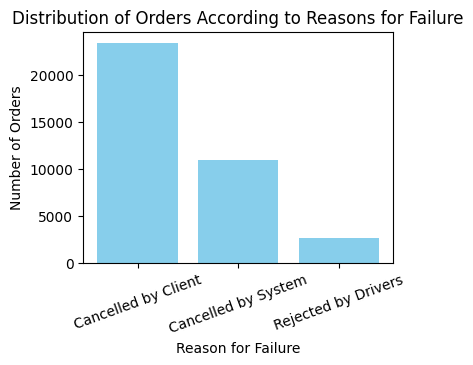

In [69]:
import matplotlib.pyplot as plt

# Create labels and counts
categories = ['Cancelled by Client', 'Cancelled by System', 'Rejected by Drivers']
counts = [cancelled_by_client_count, cancelled_by_system_count, rejected_by_drivers_count]

# Plotting
plt.figure(figsize=(4, 3))
plt.bar(categories, counts, color='skyblue')
plt.title('Distribution of Orders According to Reasons for Failure')
plt.xlabel('Reason for Failure')
plt.ylabel('Number of Orders')
plt.xticks(rotation=20)
plt.show()


### Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

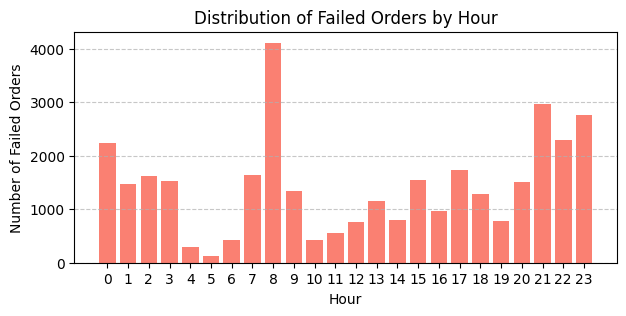

In [76]:
# Convert order_datetime to datetime object
merged_data['order_datetime'] = pd.to_datetime(merged_data['order_datetime'])

# Extract hour component
merged_data['order_hour'] = merged_data['order_datetime'].dt.hour

# Filter failed orders
failed_orders = merged_data[(merged_data['order_status_key'].isin([4, 9])) | (merged_data['offer_id'].isnull())]

# Group by hour and count failed orders
failed_orders_by_hour = failed_orders.groupby('order_hour').size().reset_index(name='count')

# Plotting
plt.figure(figsize=(7, 3))
plt.bar(failed_orders_by_hour['order_hour'], failed_orders_by_hour['count'], color='salmon')
plt.title('Distribution of Failed Orders by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Failed Orders')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

After analyzing the plot, certain hours have abnormally high proportions of one category or another, it could indicate various factors such as:

Peak demand hours: Higher cancellation rates during peak hours due to increased demand or limited availability of drivers.

System issues: System cancellations may occur during maintenance windows or when system errors are more likely to happen.

Driver behavior: Certain hours may have a higher rate of rejected orders due to driver preferences, shift changes, or traffic conditions.

### Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [98]:
# Filter out outliers for cancellation time
quantile_95 = ordf['cancellations_time_in_seconds'].quantile(0.95)
data_orders_filtered = ordf[ordf['cancellations_time_in_seconds'] <= quantile_95]

# Convert order_datetime to datetime object
data_orders_filtered['order_datetime'] = pd.to_datetime(data_orders_filtered['order_datetime'])
data_orders_filtered['order_hour'] = data_orders_filtered['order_datetime'].dt.hour

# Calculate average cancellation time with and without driver by hour
avg_time_with_driver = data_orders_filtered[data_orders_filtered['is_driver_assigned_key'] == 1].groupby('order_hour')['cancellations_time_in_seconds'].mean()

avg_time_without_driver = data_orders_filtered[data_orders_filtered['is_driver_assigned_key'] == 0].groupby('order_hour')['cancellations_time_in_seconds'].mean()

/var/folders/1w/3yn8p3z14cgbwfnfkpprjhc00000gn/T/ipykernel_34764/1260712013.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_orders_filtered['order_datetime'] = pd.to_datetime(data_orders_filtered['order_datetime'])
/var/folders/1w/3yn8p3z14cgbwfnfkpprjhc00000gn/T/ipykernel_34764/1260712013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_orders_filtered['order_hour'] = data_orders_filtered['order_datetime'].dt.hour


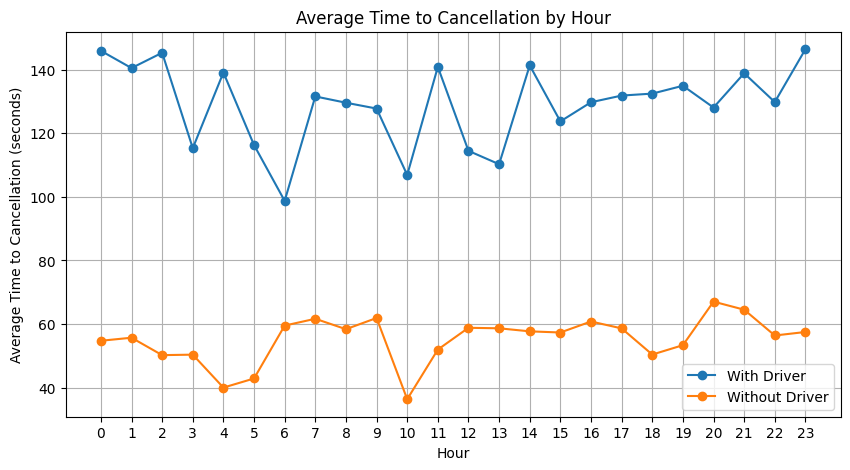

In [97]:
plt.figure(figsize=(10, 5))
# with driver
plt.plot(avg_time_with_driver.index, avg_time_with_driver.values, marker='o', label='With Driver')
# without driver
plt.plot(avg_time_without_driver.index, avg_time_without_driver.values, marker='o', label='Without Driver')

plt.title('Average Time to Cancellation by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Time to Cancellation (seconds)')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

The average time to cancellation with a driver is consistently higher than without a driver. There are significant fluctuations between the two lines, it could imply varying demand patterns or driver behavior throughout the day.

### Plot the distribution of average ETA by hours. How can this plot be explained?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


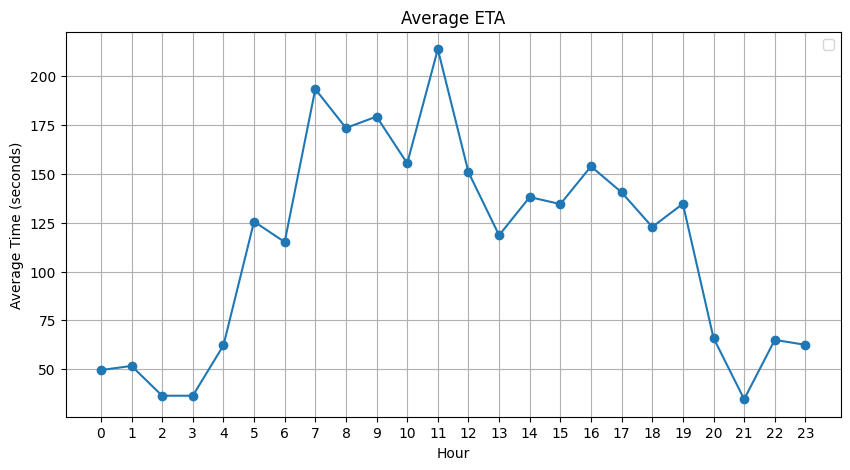

In [99]:
avg_eta = data_orders_filtered.groupby('order_hour')['m_order_eta'].mean()


plt.figure(figsize=(10, 5))
plt.plot(avg_eta.index, avg_eta.values, marker='o')

plt.title('Average ETA')
plt.xlabel('Hour')
plt.ylabel('Average Time (seconds)')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()


The trand here can be explained as there are significant fluctuations or patterns in the plot, it indicates that the average ETA varies depending on the hour. This could be due to factors such as traffic conditions, driver availability, or demand fluctuations throughout the day.

The average ETA is higher during rush hours (7-11am), it suggests increased traffic congestion or fewer available drivers during those times. Conversely, lower average ETAs during off-peak hours may indicate smoother traffic flow and higher driver availability.

### BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [100]:
!pip install h3 folium


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 902 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 56 kB 6.6 MB/s eta 0:00:011
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [101]:
import folium
import h3
from collections import Counter

In [102]:
def lat_lng_to_h3(row):
    lat, lng = row['origin_latitude'], row['origin_longitude']
    return h3.geo_to_h3(lat, lng, 8)

merged_data['hex_id'] = merged_data.apply(lat_lng_to_h3, axis=1)


In [103]:
hex_counts = Counter(merged_data['hex_id'])


In [104]:
total_orders = len(merged_data)
total_order_count = 0
top_hexes = []
for hex_id, count in hex_counts.most_common():
    total_order_count += count
    top_hexes.append(hex_id)
    if total_order_count >= 0.8 * total_orders:
        break


In [105]:
failed_orders_by_hex = merged_data[merged_data['order_status_key'].isin([4, 9])].groupby('hex_id').size().reset_index(name='failed_count')


In [106]:
m = folium.Map(location=[merged_data['origin_latitude'].mean(), merged_data['origin_longitude'].mean()], zoom_start=10)

for hex_id in top_hexes:
    hex_center = h3.h3_to_geo(hex_id)
    hex_failed_count = failed_orders_by_hex[failed_orders_by_hex['hex_id'] == hex_id]['failed_count'].iloc[0]
    folium.RegularPolygonMarker(
        location=hex_center,
        fill_color='red',
        number_of_sides=6,
        radius=10,
        popup=f'Hex ID: {hex_id}<br>Failed Orders: {hex_failed_count}'
    ).add_to(m)

m.save('hex_map.html')
